<a name="Top"></a>
# The Migdal Effect

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
mpl.rc_file('matplotlibrc')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

from scipy.integrate import simps,quad
from scipy.interpolate import interp1d

import DMUtils_migdal as DMU

from tqdm import tqdm

#from WIMpy import DMUtils as DMU_standard

import os
import glob

### Plotting the minimum DM velocity

Try a 2-D plot of vmin as a function of E_R and E_EM

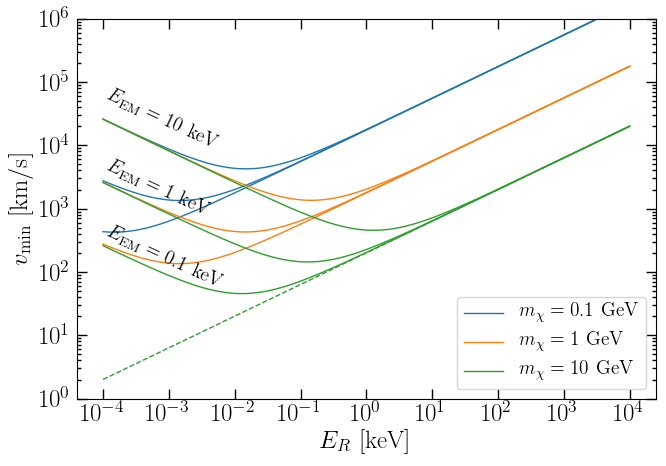

In [4]:
A_Ge = 72.64

E_list = np.logspace(-4, 4,101)

plt.figure(figsize=(7,5))

plt.loglog(E_list, DMU.vmin_migdal(E_list, 0.1, A_Ge, 0.1), color='C0', label=r'$m_\chi = 0.1\,\,\mathrm{GeV}$')
plt.loglog(E_list, DMU.vmin_migdal(E_list, 0.1, A_Ge, 1), color='C0')
plt.loglog(E_list, DMU.vmin_migdal(E_list, 0.1, A_Ge, 10), color='C0')

plt.loglog(E_list, DMU.vmin_migdal(E_list, 1.0, A_Ge, 0.1), color='C1', label=r'$m_\chi = 1\,\,\mathrm{GeV}$')
plt.loglog(E_list, DMU.vmin_migdal(E_list, 1.0, A_Ge, 1), color='C1')
plt.loglog(E_list, DMU.vmin_migdal(E_list, 1.0, A_Ge, 10), color='C1')
#plt.loglog(E_list, DMU.vmin_migdal(E_list, 1.0, A_Ge, 100), color='C1')

plt.loglog(E_list, DMU.vmin_migdal(E_list, 10.0, A_Ge, 0), color='C2', linestyle='--')
plt.loglog(E_list, DMU.vmin_migdal(E_list, 10.0, A_Ge, 0.1), color='C2', label=r'$m_\chi = 10\,\,\mathrm{GeV}$')
plt.loglog(E_list, DMU.vmin_migdal(E_list, 10.0, A_Ge, 1), color='C2')
plt.loglog(E_list, DMU.vmin_migdal(E_list, 10.0, A_Ge, 10), color='C2')

#plt.loglog(E_list, DMU.vmin_migdal(E_list, 10.0, A_Ge, 100), color='C2')

plt.text(1e-4, 5e1, r"$E_\mathrm{EM} = 0.1\,\,\mathrm{keV}$", rotation=-25, fontsize=14.0)
plt.text(1e-4, 7e2, r"$E_\mathrm{EM} = 1\,\,\mathrm{keV}$", rotation=-25, fontsize=14.0)
plt.text(1e-4, 8e3, r"$E_\mathrm{EM} = 10\,\,\mathrm{keV}$", rotation=-25, fontsize=14.0)



plt.legend(fontsize=14.0, loc='lower right')

plt.ylim(1, 1e6)

plt.xlabel(r'$E_R\,\,[\mathrm{keV}]$')
plt.ylabel(r'$v_\mathrm{min}\,\,[\mathrm{km/s}]$')

plt.xticks(np.logspace(-4,4, 9))

plt.tight_layout()

plt.savefig("../plots/Vmin_migdal.pdf", bbox_inches='tight')

plt.show()
           

### Transition probabilities

Don't worry too much about this code - it just turned out to be tricky to write some code which plots the results for each (n,l) orbital separately. 

Compare with Fig. 4 of https://arxiv.org/abs/1707.07258.



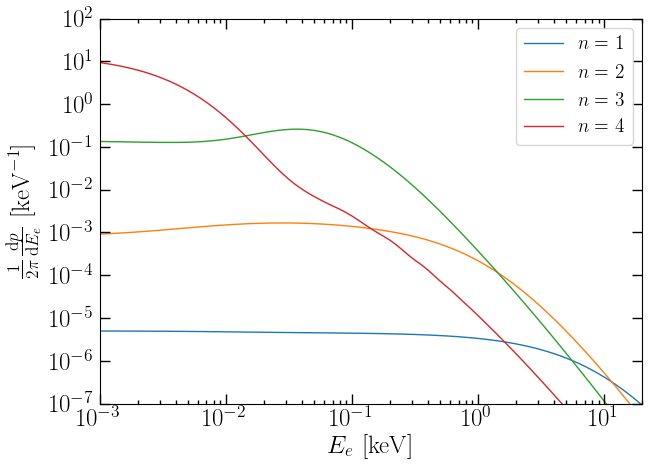

In [5]:

def plot_nl(n, l):
    E, p = DMU.load_probabilities("Ge", n, l)
    qe = 1e-3*511e3
    plt.loglog(E*1e-3, 1e3*p*qe**2/(2*np.pi), label=r'$n = ' + str(n) + ', l = ' + str(l) + '$')

def plot_n(n):
    E_list = np.logspace(-3, 2, 101)
    qe = 1e-3*511e3
    
    p = DMU.calc_ptrans(n,0, qe, E_list)
    if (n == 4):
        p += DMU.calc_ptrans(n,1, qe, E_list)
    elif (n > 1):
        for l in range(1,n):
            #print(n,l)
            p += DMU.calc_ptrans(n,l, qe, E_list)
    
    plt.loglog(E_list, p/(2*np.pi), label=r'$n = ' + str(n) + '$')
    
def plot_n_new(n):
    E_list = np.logspace(-3, 2, 101)
    qe = 1e-3*511e3
    
    p = DMU.calc_ptrans(n,0, qe, E_list)
    if (n == 4):
        p += DMU.calc_ptrans(n,1, qe, E_list)
    elif (n > 1):
        for l in range(1,n):
            #print(n,l)
            p += DMU.calc_ptrans(n,l, qe, E_list)
    
    plt.loglog(E_list, p/(2*np.pi), label=r'$n = ' + str(n) + '$')
    
plt.figure(figsize=(7,5))

plot_n(1)
plot_n(2)
plot_n(3)
plot_n(4)
#plot_nl(2, 0)
#plot_nl(2, 1)

plt.legend(fontsize=14)

plt.xlabel(r'$E_e \,\,[\mathrm{keV}]$')
plt.ylabel(r'$\frac{1}{2\pi} \frac{\mathrm{d}p}{\mathrm{d}E_e} \,\,[\mathrm{keV}^{-1}]$')

plt.ylim(1e-7, 1e2)
plt.xlim(1e-3, 20)

plt.yticks(np.logspace(-7, 2, 10))

plt.show()

### 'Total Ionisation probability'

Calculate the ionisation probability:

$$ \left|Z(E_\mathrm{NR}, E_\mathrm{EM})\right|^2$$

In [6]:
Ne = 101
N_NR = Ne
N_EM = Ne
ER_list = np.logspace(-2, 1, Ne)
EEM_list = np.logspace(-2, 1, Ne)

ER_grid, EEM_grid = np.meshgrid(ER_list, EEM_list, indexing='ij')

Z = ER_grid*0.0
for i in tqdm(range(Ne)):
    for j in range(Ne):
        Z[i,j] = DMU.dpdE_tot(ER_list[i], EEM_list[j], A_Ge)


100%|██████████| 101/101 [00:01<00:00, 59.43it/s]


/Users/bradkav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Log scale: values of z <= 0 have been masked
  import sys


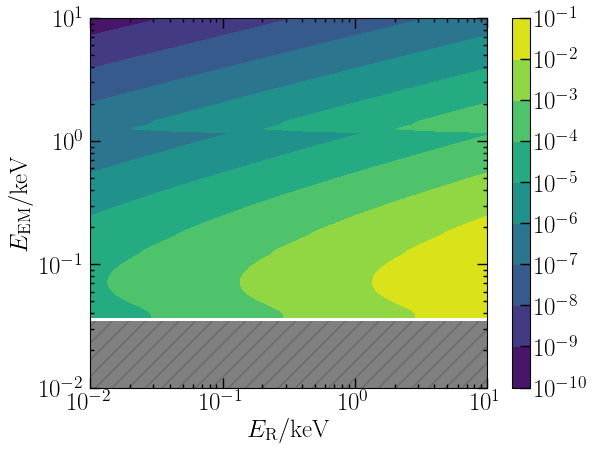

In [7]:
plt.figure()

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.contourf(ER_list, EEM_list, np.clip(Z.T, 0, 100),locator=ticker.LogLocator())

plt.fill_between(ER_list, np.min(EEM_list), 3.5e1*1e-3, facecolor='grey', hatch='//')

plt.xlabel(r'$E_\mathrm{R}/\mathrm{keV}$')
plt.ylabel(r'$E_\mathrm{EM}/\mathrm{keV}$')

plt.colorbar()

plt.savefig('../plots/p_full.pdf', bbox_inches='tight')

plt.show()

#### Neutrons


In [8]:
m_n = 939.565e-3
def v_neutron(E_n):
    return np.sqrt(2*E_n/m_n)*3e5 #km/s

Plotting the minimum velocity for *neutrons*:

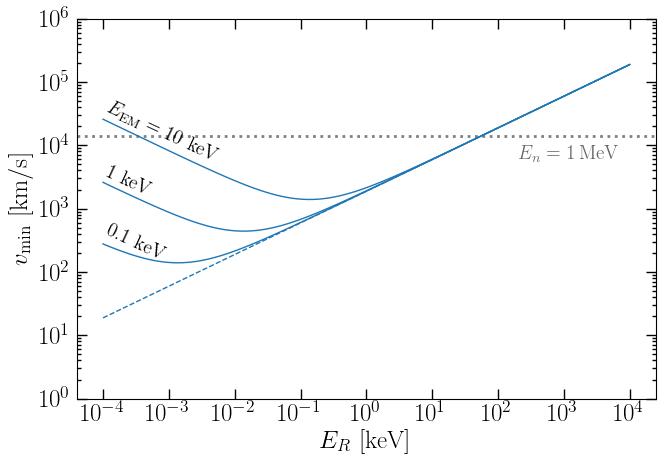

In [9]:
A_Ge = 72.64

E_list = np.logspace(-4, 4,101)

plt.figure(figsize=(7,5))

#plt.axhline(v_neutron(0.01*1e-3), color='grey', linestyle=':',lw=2)
plt.axhline(v_neutron(1e-3), color='grey', linestyle=':',lw=2)

plt.loglog(E_list, DMU.vmin_migdal(E_list, m_n, A_Ge, 0), color='C0', linestyle='--')
plt.loglog(E_list, DMU.vmin_migdal(E_list, m_n, A_Ge, 0.1), color='C0')
plt.loglog(E_list, DMU.vmin_migdal(E_list, m_n, A_Ge, 1), color='C0')
plt.loglog(E_list, DMU.vmin_migdal(E_list, m_n, A_Ge, 10), color='C0')


#plt.loglog(E_list, DMU.vmin_migdal(E_list, 10.0, A_Ge, 100), color='C2')

plt.text(1e-4, 1.5e2, r"$0.1\,\,\mathrm{keV}$", rotation=-25, fontsize=14.0)
plt.text(1e-4, 1.5e3, r"$1\,\,\mathrm{keV}$", rotation=-25, fontsize=14.0)
plt.text(1e-4, 5e3, r"$E_\mathrm{EM} = 10\,\,\mathrm{keV}$", rotation=-25, fontsize=14.0)

plt.text(2e2, 9e3, r"$E_n = 1\,\mathrm{MeV}$", va='top', ha='left', fontsize=14.0, color='dimgrey')

#plt.legend(fontsize=14.0, loc='lower right')

plt.ylim(1, 1e6)

plt.xlabel(r'$E_R\,\,[\mathrm{keV}]$')
plt.ylabel(r'$v_\mathrm{min}\,\,[\mathrm{km/s}]$')

plt.xticks(np.logspace(-4,4, 9))

plt.tight_layout()

plt.savefig("../plots/Vmin_migdal_neutron.pdf", bbox_inches='tight')

plt.show()
           

#### Double-differential rate

Calculate $\mathrm{d}R/\mathrm{d}E_\mathrm{NR}\mathrm{d}E_\mathrm{EM}$:

In [10]:
#neutron-nucleus scattering rate
alpha = 2.72e-4
beta = 0.124
def dRdE(E):
    return alpha*np.exp(-beta*E)

#Normalise it 'per recoil'
norm = beta/alpha

/Users/bradkav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Log scale: values of z <= 0 have been masked
  from ipykernel import kernelapp as app


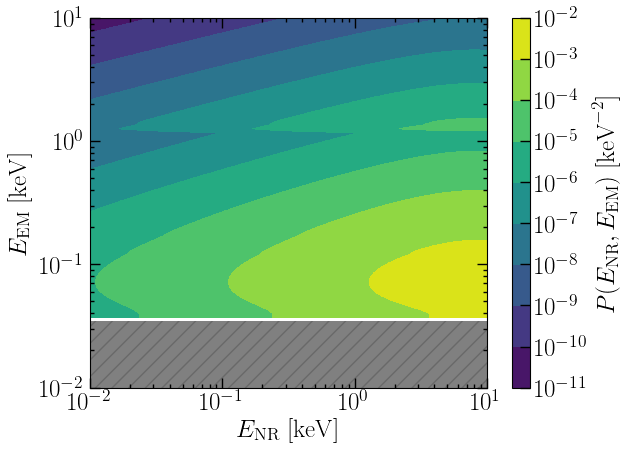

In [11]:
#These 'grids' are defined above
d2R_dENRdEEM = Z*norm*dRdE(ER_grid)

hdrtxt="P(E_NR, E_EM), per neutron-Ge recoil, where E_NR is the nuclear recoil and E_EM is the total electronic energy\n"
hdrtxt+="Each column corresponds to a flattened 100x100 grid containing: E_NR [keV], E_EM [keV], P(E_NR, E_EM) [keV^-2]"

np.savetxt("d2R_grid.txt", list(zip(ER_grid.flatten(), EEM_grid.flatten(), d2R_dENRdEEM.flatten())), header=hdrtxt)

plt.figure()

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.contourf(ER_list, EEM_list, np.clip(d2R_dENRdEEM.T, 0, 100),locator=ticker.LogLocator())

plt.fill_between(ER_list, np.min(EEM_list), 3.5e1*1e-3, facecolor='grey', hatch='//')

plt.xlabel(r'$E_\mathrm{NR}$ $[\mathrm{keV}]$')
plt.ylabel(r'$E_\mathrm{EM}$ $[\mathrm{keV}]$')

plt.colorbar(label = r'$P(E_\mathrm{NR}, E_\mathrm{EM})$ $[\mathrm{keV}^{-2}]$')

plt.savefig('../plots/d2R.pdf', bbox_inches='tight')

plt.show()